In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import xgboost

import optuna

import wandb
from wandb.keras import WandbCallback

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/ticks_day.csv')
data.day = pd.to_datetime(data.day)

In [3]:
data.head()

,region,day,test,positive,negative
0,Челябинская обл,2019-02-13,Borrelia burgdorferi s.l (кач) ДНК,0,0
1,Челябинская обл,2019-02-14,Borrelia burgdorferi s.l (кач) ДНК,0,0
2,Челябинская обл,2019-02-15,Borrelia burgdorferi s.l (кач) ДНК,0,0
3,Челябинская обл,2019-02-16,Borrelia burgdorferi s.l (кач) ДНК,0,0
4,Челябинская обл,2019-02-17,Borrelia burgdorferi s.l (кач) ДНК,0,0


In [4]:
data.isna().sum()

region      0
day         0
test        0
positive    0
negative    0
dtype: int64

In [5]:
tests = data.test.unique()

In [6]:
# using only months from April to October, because from November to March the number of testings is almost zero.
data = data[(data.day.dt.month > 3) & (data.day.dt.month < 11)]

In [7]:
region_grouped = data.groupby(data.region).sum()
region_grouped

,positive,negative
region,,
Адыгея Респ,3,19
Алтай Респ,0,74
Алтайский край,1,339
Астраханская обл,0,9
Башкортостан Респ,1234,8406
...,...,...
Челябинская обл,14701,143952
Чеченская Респ,0,2
Чувашская Респ,5,63


In [8]:
#predict only in regions with the enougth number of testings
target_regions = region_grouped[region_grouped.positive + region_grouped.negative > 100].index
len(target_regions)

39

In [9]:
n_future = 20

## Stationarity check

In [7]:
region_test_grouped = data.groupby([data.region, data.test]).sum()

In [8]:
region_test_grouped['total'] = region_test_grouped.positive + region_test_grouped.negative

In [9]:
adf_results = pd.DataFrame()
for region in target_regions:
    for test in tests:
        total = region_test_grouped.loc[(region, test)].total
        if total < 1000:
            continue
            
        data_slice = data[(data.region == region) & (data.test == test)].negative
        adf = adfuller(data_slice)
        adf_results = adf_results.append(
            pd.DataFrame({
                'region': region,
                'test': test,
                'total': total,
                'adf_value': adf[0], 
                'p_value': adf[1] 
        }, index=[0]), ignore_index=True)

In [10]:
adf_results.sort_values(by='p_value', ascending=False)

,region,test,total,adf_value,p_value
25,Челябинская обл,Borrelia miyamotoi (кач) ДНК,10441,-1.777038,0.391920
16,Новосибирская обл,Anaplasma Phagocytophillum(кач) ДНК,2625,-1.791077,0.384901
15,Новосибирская обл,Ehrlichia muris/chaffeеnsis(кач) ДНК,2626,-1.793138,0.383874
19,Свердловская обл,Ehrlichia muris/chaffeеnsis(кач) ДНК,7209,-1.862084,0.350103
1,Башкортостан Респ,Вирус клещевого энцефалита(кач) РНК,3769,-1.918092,0.323598
18,Свердловская обл,Вирус клещевого энцефалита(кач) РНК,22175,-1.931971,0.317173
21,Свердловская обл,Anaplasma Phagocytophillum(кач) ДНК,7212,-1.986375,0.292579
17,Свердловская обл,Borrelia burgdorferi s.l (кач) ДНК,22105,-2.010583,0.281952
13,Новосибирская обл,Borrelia burgdorferi s.l (кач) ДНК,3763,-2.156455,0.222427
20,Свердловская обл,Borrelia miyamotoi (кач) ДНК,7689,-2.235822,0.193502


In [11]:
region = 'Челябинская обл '
test = 'Borrelia miyamotoi (кач) ДНК'

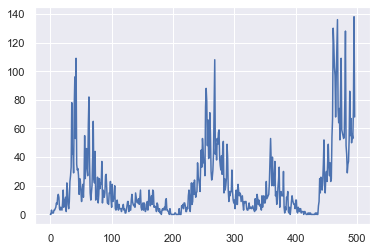

In [12]:
data_slice = data[(data.region == region) & (data.test == test)]
data_slice.index = range(len(data_slice))
plt.plot(data_slice.index, data_slice.negative)

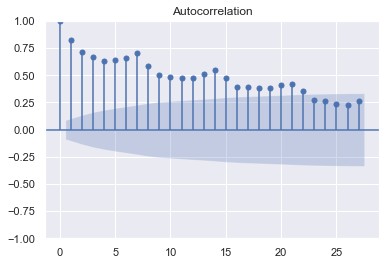

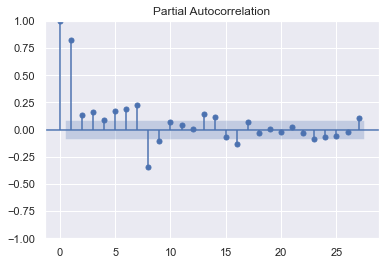

In [13]:
plot_acf(data_slice.negative)
plot_pacf(data_slice.negative)
plt.show()

In [14]:
print(f'Initial series ADF test p-value:\n{adfuller(data_slice.negative)[1]}')

Initial series ADF test p-value:
0.39191996611105695


In [15]:
for col in ['positive', 'negative']:
    data_slice[f'log_{col}'] = np.nan_to_num(np.log(data_slice[col]), neginf=0)

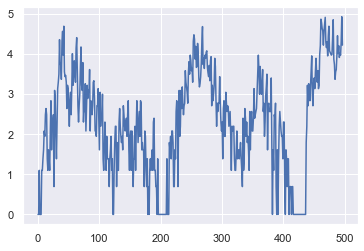

In [16]:
plt.plot(data_slice.log_negative)

In [17]:
for col in ['positive', 'negative']:
    data_slice[f'log_week_dif_{col}'] = data_slice[f'log_{col}'].diff(7).fillna(0)

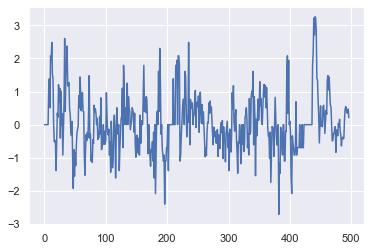

In [18]:
plt.plot(data_slice.log_week_dif_negative)

In [19]:
print(f'Logged and week differenciated series ADF test p-value:\n{adfuller(data_slice.log_week_dif_negative)[1]}')

Logged and week differenciated series ADF test p-value:
2.2392272270825353e-05


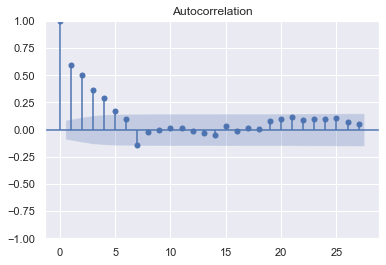

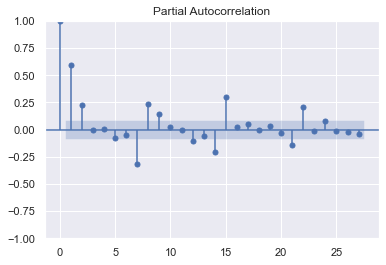

In [20]:
plot_acf(data_slice.log_week_dif_negative)
plot_pacf(data_slice.log_week_dif_negative)
plt.show()

#### Conclusion: logarithm and week differenciating made series stationary. But we still have strong partial correlation on every 7 and 8 day.
---

In [21]:
def sarima_optimization(series, 
                        p_range, d_range, q_range, 
                        P_range, D_range, Q_range, s=0):
    result_df = pd.DataFrame()
    
    for trend_params in [(p, d, q) for p in p_range for d in d_range for q in q_range]:
        for seasonal_params in [(P, D, Q, s) for P in P_range for D in D_range for Q in Q_range]:
            model = SARIMAX(series, order=trend_params, 
                            seasonal_order=seasonal_params).fit()

            result_df = result_df.append(pd.DataFrame({
                'trend_params': str(trend_params),
                'seasonal_params': str(seasonal_params),
                'AIC': model.aic
            }, index=[0]), ignore_index=True)
            
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [22]:
sarima_optimization(data_slice.log_week_dif_negative, 
                    [0], [0], [0], # no trend in data
                    [0, 1, 2], [0, 1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 2], 
                    s=7)

,trend_params,seasonal_params,AIC
0,"(0, 0, 0)","(2, 0, 2, 7)",1248.736986
1,"(0, 0, 0)","(0, 0, 1, 7)",1260.929083
2,"(0, 0, 0)","(2, 0, 0, 7)",1261.317342
3,"(0, 0, 0)","(1, 0, 0, 7)",1261.729300
4,"(0, 0, 0)","(2, 0, 1, 7)",1261.794977
...,...,...,...
76,"(0, 0, 0)","(0, 8, 0, 7)",3226.418863
77,"(0, 0, 0)","(2, 8, 1, 7)",3234.564687
78,"(0, 0, 0)","(0, 8, 2, 7)",4157.588464
79,"(0, 0, 0)","(0, 8, 1, 7)",4687.159652


In [23]:
best_trend_param = (0, 0, 0)
best_seasonal_param = (2, 8, 2, 7)
sarima_model = SARIMAX(data_slice.log_week_dif_negative, order=best_trend_param, 
                       seasonal_order=best_seasonal_param).fit()

In [24]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:        log_week_dif_negative   No. Observations:                  497
Model:             SARIMAX(2, 8, [1, 2], 7)   Log Likelihood               -2370.873
Date:                      Tue, 14 Jun 2022   AIC                           4751.745
Time:                              15:41:48   BIC                           4772.190
Sample:                                   0   HQIC                          4759.810
                                      - 497                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.0024      0.004     -0.661      0.508      -0.010       0.005
ar.S.L14       0.9976      0.004    274.142      0.000       0.990       1.005
ma.S.L7        1.9984      0.033     60.344      0.000       1.933       2.063
ma.S.L14       0.9991      0.033     29.967      0.000       0.934       1.064
sigma2         3.4565      0.063     55.269      0.000       3.334       3.579
===================================================================================
Ljung-Box (L1) (Q):                  24.23   Jarque-Bera (JB):                 2.39
Prob(Q):                              0.00   Prob(JB):                         0.30
Heteroskedasticity (H):               2.99   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

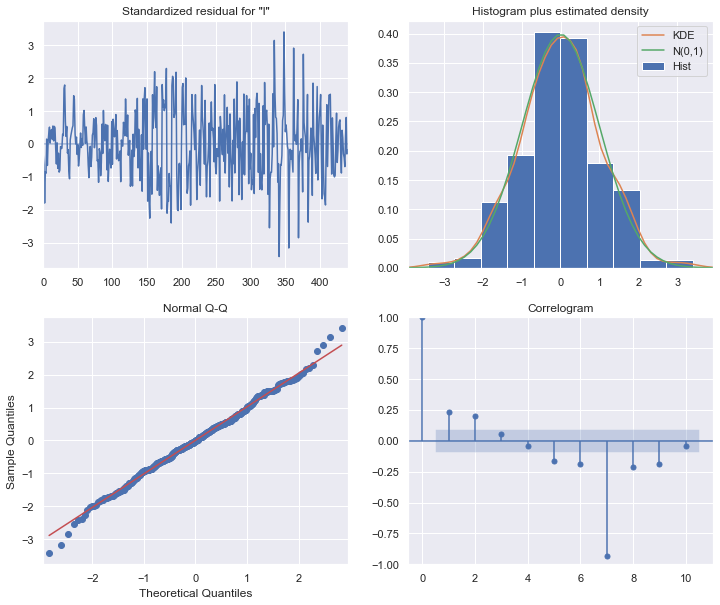

In [25]:
sarima_model.plot_diagnostics(figsize=(12,10))
plt.show()

#### Conclusion: residuals don't look like white noise, there is still weekly peaks and seasonal dependense - due to the inability to use a yearly period with a daily data. SARIMA is not suitable for this task.
---

## Train, validation and test split

In [10]:
data = pd.read_csv('data/ticks_weather.csv')
data.day = pd.to_datetime(data.day)
data = data[data.region.isin(target_regions)]

In [11]:
data.head()

,region,day,test,positive,negative,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,Челябинская обл,2019-02-13,Borrelia burgdorferi s.l (кач) ДНК,0,0,-4,-11,0.0,7.0,1,...,-13,17,32,83,0.0,1033,-4,10,211,9
1,Челябинская обл,2019-02-13,Вирус клещевого энцефалита(кач) РНК,0,0,-4,-11,0.0,7.0,1,...,-13,17,32,83,0.0,1033,-4,10,211,9
2,Челябинская обл,2019-02-13,Ehrlichia muris/chaffeеnsis(кач) ДНК,0,0,-4,-11,0.0,7.0,1,...,-13,17,32,83,0.0,1033,-4,10,211,9
3,Челябинская обл,2019-02-13,Borrelia miyamotoi (кач) ДНК,0,0,-4,-11,0.0,7.0,1,...,-13,17,32,83,0.0,1033,-4,10,211,9
4,Челябинская обл,2019-02-13,Anaplasma Phagocytophillum(кач) ДНК,0,0,-4,-11,0.0,7.0,1,...,-13,17,32,83,0.0,1033,-4,10,211,9


In [12]:
test_split_date = data.day.max() - pd.Timedelta(f'{n_future} days')
val_split_date = test_split_date - pd.Timedelta(f'{n_future} days')

In [13]:
train_data = data[data.day <= val_split_date]
val_data = data[(data.day > val_split_date) & (data.day <= test_split_date)]
test_data = data[data.day > test_split_date]

In [14]:
print(f'Train examples: {len(train_data)}')
print(f'Validation examples: {len(val_data)}')
print(f'Test examples: {len(test_data)}')

Train examples: 157365
Validation examples: 3900
Test examples: 3900


## LSTM model

### Data preparation

In [15]:
targets = ['positive', 'negative']
simple_features = targets

In [16]:
n_features = len(simple_features)
n_past = 7

In [17]:
def scale_columns(df, columns, scalers):
    if scalers is None:
        scalers = {}
        for col in columns:
            scaler = StandardScaler().fit(df[[col]])
            df[col] = scaler.transform(df[[col]])
            scalers[col] = scaler

    else:
        for col in columns:
            scaler = scalers.get(col)
            df[col] = scaler.transform(df[[col]])

    return df, scalers

In [18]:
train_data, scalers = scale_columns(train_data, columns=simple_features, scalers=None)
val_data, scalers = scale_columns(val_data, columns=simple_features, scalers=scalers)
test_data, scalers = scale_columns(test_data, columns=simple_features, scalers=scalers)

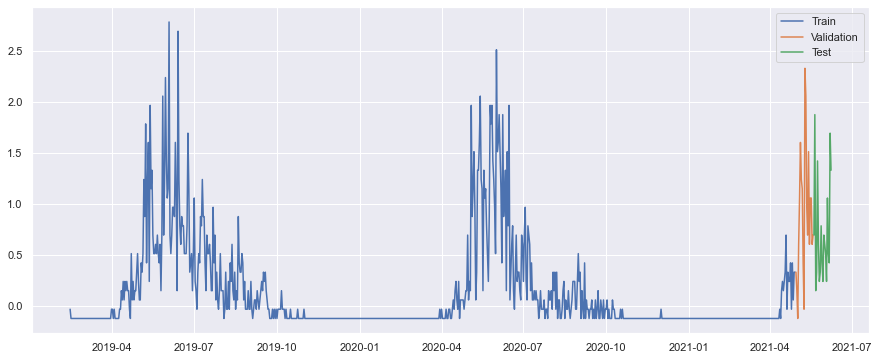

In [108]:
i = 1
region = target_regions[i]
test = tests[0]
train_slice = train_data[(train_data.region == region) & (train_data.test == test)]
val_slice = val_data[(val_data.region == region) & (val_data.test == test)]
test_slice = test_data[(test_data.region == region) & (test_data.test == test)]
plt.figure(figsize=(15,6))
plt.plot(train_slice.day, train_slice.negative, label='Train')
plt.plot(val_slice.day, val_slice.negative, label='Validation')
plt.plot(test_slice.day, test_slice.negative, label='Test')
plt.legend()
plt.show()

In [19]:
def split_train(df, n_past, n_future, features, targets):
    X, y = [], []
    for region in df.region.unique():
        for test in df.test.unique():
            data_slice = df[(df.region == region) & (df.test == test)]
            
            for start in range(len(data_slice)):
                past_end = start + n_past
                future_end = past_end + n_future
                if future_end > len(data_slice):
                    break

                past = data_slice.loc[data_slice.index[start:past_end]][features].values
                future = data_slice.loc[data_slice.index[past_end:future_end]][targets].values
                X.append(past)
                y.append(future)
                
    return np.array(X), np.array(y)

In [20]:
def split_test(train_data, test_data, n_past, features, targets):
    X_test, y_test = [], []
    df = train_data[train_data.day > (train_data.day.max() - pd.Timedelta(f'{n_past} days'))]
    for region in df.region.unique():
        for test in df.test.unique():
            x_slice = df[(df.region == region) & (df.test == test)][features]
            y_slice = test_data[(test_data.region == region) & (test_data.test == test)][targets]
            X_test.append(x_slice)
            y_test.append(y_slice)
    return np.array(X_test), np.array(y_test)

In [21]:
X_train, y_train = split_train(train_data, n_past, n_future, simple_features, targets)
X_val, y_val = split_test(train_data, val_data, n_past, simple_features, targets)
X_test, y_test = split_test(val_data, test_data, n_past, simple_features, targets)

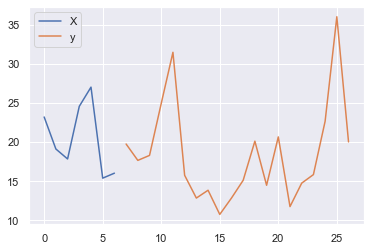

In [99]:
plt.plot(range(len(X_test[i][:, 1])), X_test[i][:, 1], label='X')
plt.plot(range(len(X_test[i][:, 1]), len(X_test[i][:, 1]) + len(y_test[i][:, 1])), y_test[i][:, 1], label='y')
plt.legend()
plt.show()

### Baseline

In [23]:
class DumbModel:
    def __init__(self, out_len):
        self.out_len = out_len
        
    def predict(self, X):
        # simply return mean for last prediod (out_len days)
        return np.ones((X_test.shape[0], self.out_len, X_test.shape[2])) * np.mean(X, axis=(0,1))

In [24]:
dumb_model = DumbModel(n_future)

In [25]:
pred = dumb_model.predict(X_test)

In [26]:
def print_metrics(pred, true):
    print(f'Positive samples MAE: {mean_absolute_error(pred[:,:,0], true[:,:,0])}')
    print(f'Negative samples MAE: {mean_absolute_error(pred[:,:,1], true[:,:,1])}')
    print(f'All samples MAE: {mean_absolute_error(pred.flatten(), true.flatten())}')

In [27]:
print_metrics(pred, y_test)

Positive samples MAE: 0.7876805594145183
Negative samples MAE: 1.1821118358412124
All samples MAE: 0.9848961976278655


### Model

In [28]:
def create_lstm_model(input_shape, out_shape, layer_size=128):
    model = Sequential()
    model.add(layers.LSTM(layer_size, input_shape=input_shape))
    model.add(layers.RepeatVector(out_shape[0]))
    model.add(layers.LSTM(layer_size, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(out_shape[1])))
    model.compile(optimizer='adam', loss='mae')
    return model

In [29]:
lstm_model = create_lstm_model((n_past, n_features), (n_future, len(targets)))

In [30]:
n_epochs = 250
batch_size = 256

In [ ]:
run = wandb.init(project='ticks_testing_prognosis', name='lstm_simple')

In [ ]:
wandb_callback = WandbCallback(monitor='loss', log_weights=True)

In [ ]:
callbacks = [wandb_callback]

In [64]:
wandb.run

<table><tr>
<td> <img src="images/lstm_simple_loss.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="images/lstm_simple_val_mae_negative.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

In [ ]:
with tf.device('/device:GPU:0'):
    lstm_model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   epochs=n_epochs, batch_size=batch_size,
                   callbacks=callbacks)

In [74]:
lstm_model.save('lstm_simple.h5')

In [32]:
lstm_model = keras.models.load_model('lstm_simple.h5')

In [33]:
pred = lstm_model.predict(X_test)

In [67]:
def plot_predictions(true, pred, regions, n_cols=3):
    n_rows = len(regions)//n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,n_rows*4))
    i = 0
    
    for region, ax in zip(regions, axs.flatten()):
        ax.set_title(region)

        ax.plot(y_test[i][:, 1], label='Negative true')
        ax.plot(pred[i][:, 1], label='Negative pred')

        ax.plot(y_test[i][:, 0], label='Positive true')
        ax.plot(pred[i][:, 0], label='Positive pred')
        
        i+=1
        
    lines_labels = [ax.get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)    
    plt.show()  

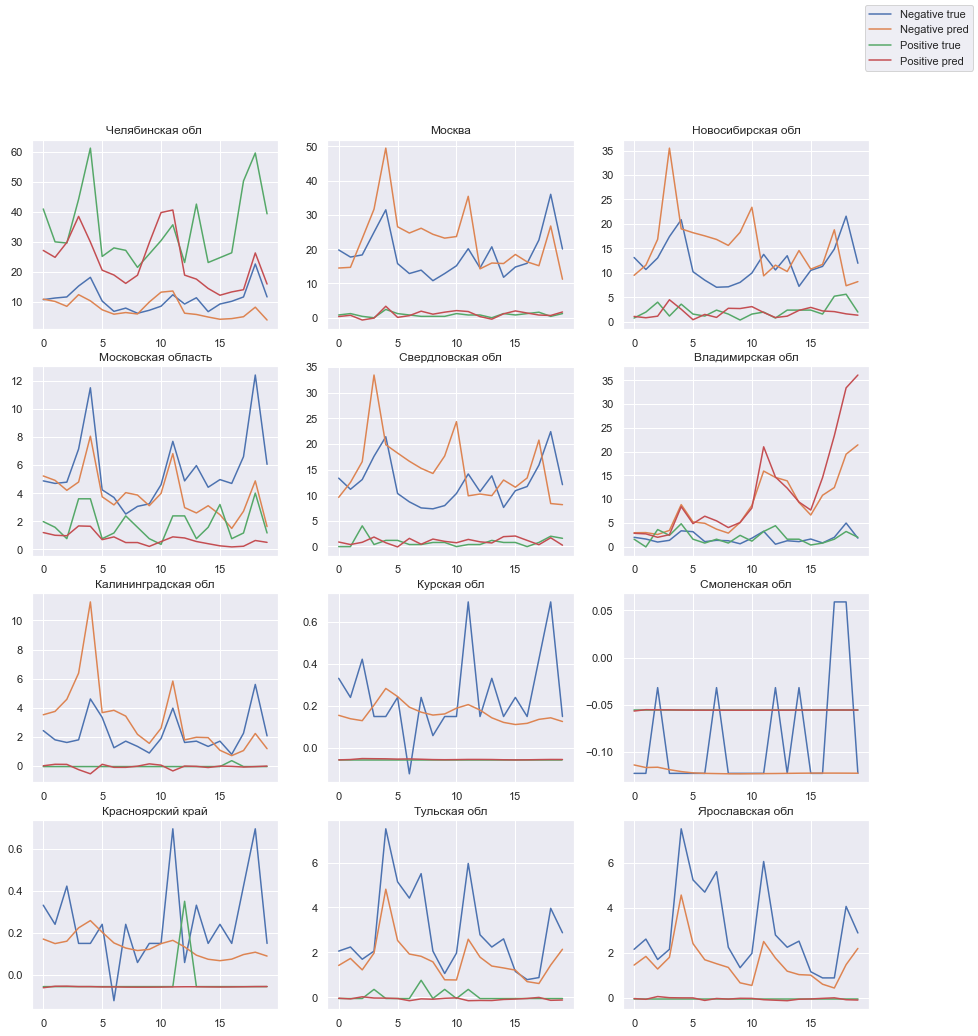

In [68]:
plot_predictions(y_test, pred, data.region.unique()[:12])

In [69]:
print_metrics(pred, y_test)

Positive samples MAE: 0.268348454634483
Negative samples MAE: 0.360679187294911
All samples MAE: 0.3145138209646966


### Adding weather features

In [70]:
data.columns

Index(['region', 'day', 'test', 'positive', 'negative', 'maxtempC', 'mintempC',
       'totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'DewPointC',
       'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover',
       'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph'],
      dtype='object')

In [71]:
weather_features = data.columns[3:]
n_features = len(weather_features)

In [72]:
X_train, y_train = split_train(train_data, n_past, n_future, weather_features, targets)
X_val, y_val = split_test(train_data, val_data, n_past, weather_features, targets)
X_test, y_test = split_test(val_data, test_data, n_past, weather_features, targets)

In [ ]:
run = wandb.init(project='ticks_testing_prognosis', name='lstm_weather')

In [73]:
lstm_model = create_lstm_model((n_past, n_features), (n_future, len(targets)))

In [36]:
wandb.run

<table><tr>
<td> <img src="images/lstm_weather_loss.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="images/lstm_weather_val_loss.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

In [ ]:
with tf.device('/device:GPU:0'):
    lstm_model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   epochs=n_epochs, batch_size=batch_size,
                   callbacks=callbacks)

In [74]:
lstm_model.save('lstm_weather.h5')

In [74]:
lstm_model = keras.models.load_model('lstm_weather.h5')

In [75]:
pred = lstm_model.predict(X_test)

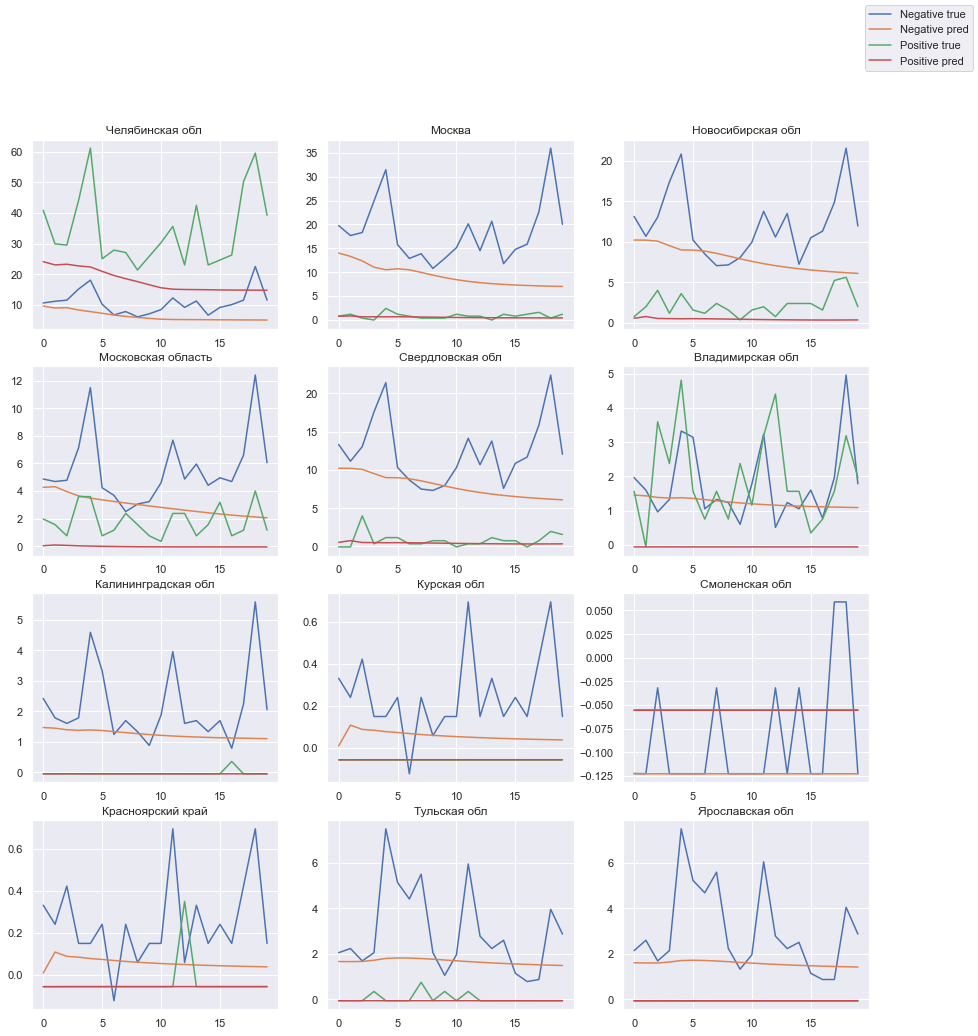

In [76]:
plot_predictions(y_test, pred, data.region.unique()[:12])

In [77]:
print_metrics(pred, y_test)

Positive samples MAE: 0.26209763477599923
Negative samples MAE: 0.38923908835936427
All samples MAE: 0.3256683615676809


#### Conclusion: LSTM model with weather features showed better MAE on validation, but it didn't learned properly (as seen on the chart above). LSTM trained only on targets showed slightly better MAE on test and learned data well.
---